# Check normalizations

The major element composition of volcanic products is expressed in wt. %, and ideally the sum of all the major oxides and LOI (when analyzed) should approach a 100 wt.%. However, because of post-depositional alteration or meteorization, pre-depostional hydration of magmas or problems during the analysis, the analytical totals are generally not exactly 100 wt. %. In order to eliminate the effects of these processes in the composition of oxides, researchers normalize the major element composition to a 100% volatile-free (also named anhydrous) basis, i.e. by the sum of the major oxides without LOI. 

Because of the heterogeneity of the data in the BOOM dataset, different major elements have been analyzed for different samples. For example, in some samples MnO, Cl and/or P2O5 might not be analyzed, thus raising the question: are sample observations normalized by *different* analytical totals still comparable?

In order to answer to that question, in this notebook, we re-normalize sample observations analyzed for major element composition by a new analytical total:

    new_Total = SiO2 + TiO2 + Al2O3 + MgO + CaO + Na2O + K2O (i.e. without MnO, P2O5 or CL) (1)

and calculate the difference between the normalized values as:

    Δ_major_element = major_element_original - major_element_new_Total (2)

Then, we compare the Δ_major_element with highest the precision (1 SD) with which the different major elements can be analyzed, given by the 1SD or 95%CL of the certified values of the geostandards analyzed along with the samples. From the comparison (3), the difference in the normalization is smaller than the precision of the different elements, and thus we conclude that sample observations normalized by *different* totals (computed as the sum of *different* major elements), can be compared.  

## Load BOOM dataset

In [4]:
import pandas as pd
import requests
from io import StringIO

#Download the dataset from the ESPRI server as .csv 
url = "https://data.ipsl.fr/repository/TephraDatabase/TephraDataBase.csv"
s=requests.get(url).text
BOOM = pd.read_csv(StringIO(s), encoding="latin1", low_memory=False)

#in case the ESPRI server is down:
#BOOM = pd.read_csv("..assets/Data/BOOMDataset.csv", encoding = 'UTF-8', low_memory =False )

# Preprocess BOOM dataset

In the BOOM dataset, the data was stored as in the original publication. Because of this, in many cases the assigned value to a particular element might not be a number but an expresion to indicate: missingness, lower than a certain value, below detection limit (bdl) or over range. In order to treat the data, these values are replaced by NAN. In order to process the data it is necesary to replace these expressions by "NaN".

In [5]:
import numpy as np

BOOM =BOOM.replace(to_replace=dict.fromkeys(['Over range','bld',
                                                         '<0.01','<0.1','<1','<5','<6','<10',
                                                         'n.a.','Not analyzed','Not Netermined','-', 'n.d.', 'n.d']),value=np.nan)

For evaluating the effect that analyzing different major elements has on their normalization, we are only interested in Sample Observations where major elements have been analyzed:

In [6]:
BOOM_major = BOOM.dropna(subset=['SiO2'],axis=0,how='any')

Now we check the missingness of the different major elements, as we can see, MnO, P2O5 and CL are less routinely analyzed than the rest of the elements.

<AxesSubplot:>

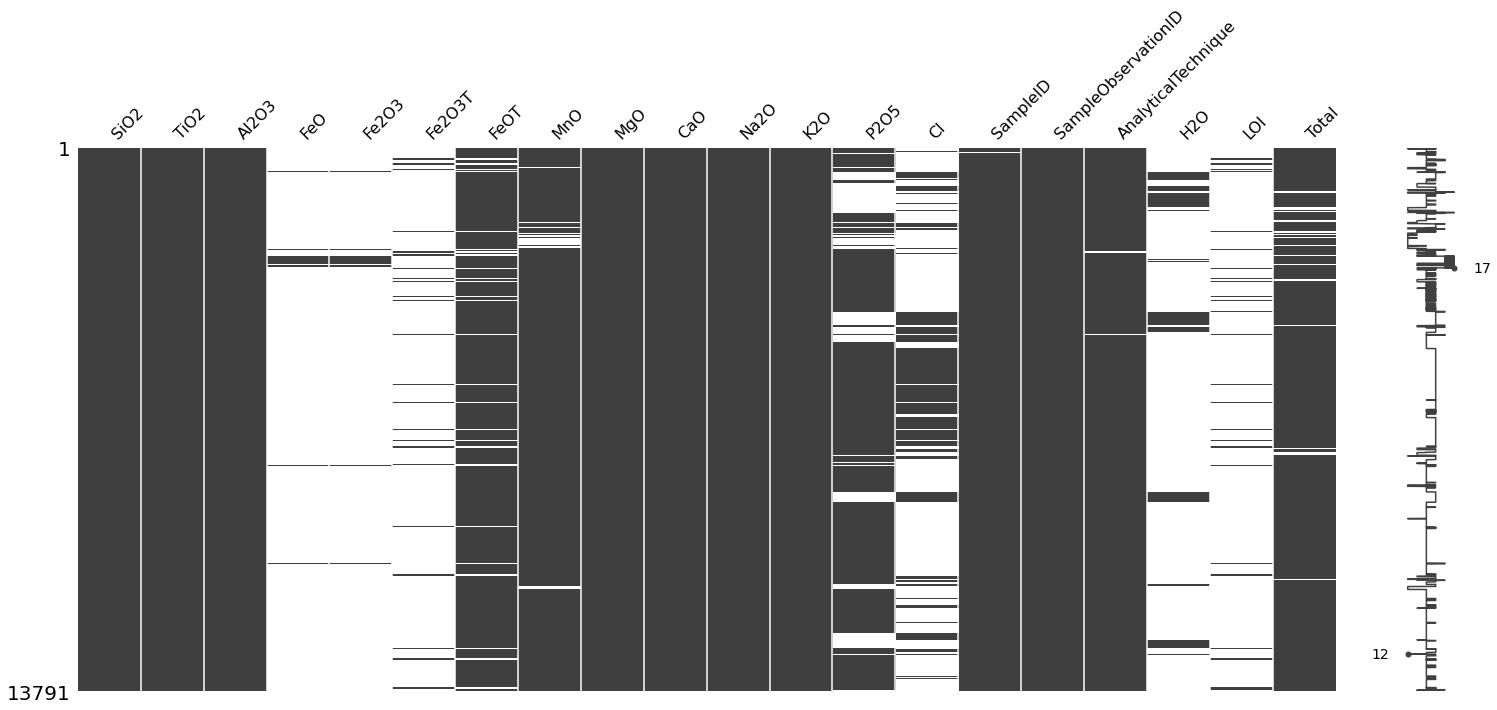

In [7]:
import missingno as msno
msno.matrix(pd.concat([BOOM_major]).loc[:,'SiO2':'Total'])

## 1 Calculating new totals and re-normalizing.

In [8]:
# (1)
import sys
sys.path.insert(1, '../Scripts')
from functions import renormalizing

BOOM_major = BOOM_major.reset_index(drop = True)
BOOM_major_renormalized= renormalizing(BOOM_major)

## 2 Calculating the difference between the two normalized values

In [9]:
# (2)
# calculate difference between normalized and re-normalized compositions
BOOM_major_renormalized['ΔSiO2'] = np.subtract(BOOM_major_renormalized['SiO2_normalized'],BOOM_major['SiO2_normalized'])
BOOM_major_renormalized['ΔTiO2'] = np.subtract(BOOM_major_renormalized['TiO2_normalized'],BOOM_major['TiO2_normalized'])
BOOM_major_renormalized['ΔAl2O3'] = np.subtract(BOOM_major_renormalized['Al2O3_normalized'],BOOM_major['Al2O3_normalized'])
BOOM_major_renormalized['ΔFeOT'] = np.subtract(BOOM_major_renormalized['FeOT_normalized'],BOOM_major['FeOT_normalized'])
BOOM_major_renormalized['ΔMgO'] = np.subtract(BOOM_major_renormalized['MgO_normalized'],BOOM_major['MgO_normalized'])
BOOM_major_renormalized['ΔCaO'] = np.subtract(BOOM_major_renormalized['CaO_normalized'],BOOM_major['CaO_normalized'])
BOOM_major_renormalized['ΔNa2O'] = np.subtract(BOOM_major_renormalized['Na2O_normalized'],BOOM_major['Na2O_normalized'])
BOOM_major_renormalized['ΔK2O'] = np.subtract(BOOM_major_renormalized['K2O_normalized'],BOOM_major['K2O_normalized'])

## 3 Compare the difference with the geostandards certified precisions

In [10]:
#load MeasurementRuns file to check the geostandards analyzed along with the samples
standard_url = "https://data.ipsl.fr/repository/TephraDatabase/TephraDataBase_Standards.csv"
s=requests.get(standard_url).text
BOOM_geostandards = pd.read_csv(StringIO(s), encoding="latin1")
BOOM_geostandards.loc[:,'MeasurementRun'] = BOOM_geostandards.loc[:,'MeasurementRun'].astype('str')
BOOM_major_renormalized.loc[:,'MeasurementRun'] = BOOM_major_renormalized.loc[:,'MeasurementRun'].astype('str')

#load the Secondary standards reference values
Standards_ref = pd.read_csv('../assets/Data/Standards_Reference.csv', encoding = 'UTF-8', low_memory =False)
Standards_ref = Standards_ref[Standards_ref.ErrorType.isin(['95%CL','SD'])].copy()

#get which secondary standards were analyzed along with the samples
BOOM_major_renormalized_bulk = BOOM_major_renormalized[BOOM_major_renormalized.TypeOfAnalysis == 'Bulk']
BOOM_major_renormalized_glass = BOOM_major_renormalized[BOOM_major_renormalized.TypeOfAnalysis == 'Micro Analytical']

stds_glass =  BOOM_geostandards[BOOM_geostandards.MeasurementRun.isin(BOOM_major_renormalized_glass.MeasurementRun.unique())].Standard.unique()
stds_bulk =  BOOM_geostandards[BOOM_geostandards.MeasurementRun.isin(BOOM_major_renormalized_bulk.MeasurementRun.unique())].Standard.unique()
Standards_ref_glass = Standards_ref[Standards_ref.StandardID.isin(stds_glass)]
Standards_ref_bulk = Standards_ref[Standards_ref.StandardID.isin(stds_bulk)]

3.1 Glass

In [ ]:
# Plot the precision for each element for each geostandard analyzed along with the samples, together with the
#     difference between normalized values. Because the precision of glass and whole-rock geostandards can be very different
#     first we plot only glass  

import plotly.express as px
import plotly.graph_objects as go

elementos = ['SiO2']# ,'TiO2','Al2O3','FeOT','MgO','CaO','Na2O','K2O']

for elemento in elementos: #['SiO2','Al2O3']:
    plot1 = go.Scatter(x=BOOM_major_renormalized_glass[elemento+'_normalized'],
               y=BOOM_major_renormalized_glass['Δ'+elemento],
               mode = 'markers',
               hovertext = 'Sample Observation ID: ' + BOOM_major_renormalized_glass.SampleObservationID.astype('str') + ' '+ 
                       BOOM_major_renormalized_glass.Authors.astype('str') + '; LOI:'+ BOOM_major_renormalized_glass.LOI.astype('str')
                       + '; P2O5:'+ BOOM_major_renormalized_glass.P2O5.astype('str')
                       + '; MnO:'+ BOOM_major_renormalized_glass.MnO.astype('str')
                       + '; Cl:'+ BOOM_major_renormalized_glass.Cl.astype('str')
                       + '; Al2O3:'+ BOOM_major_renormalized_glass.Al2O3.astype('str')
                       ,
               marker = dict(color=BOOM_major_renormalized_glass['MnO + P2O5 + Cl'],showscale = True),
               name = "MnO + P2O5 + Cl")

    plot2 = go.Scatter(x = Standards_ref_glass[elemento],
                  y = Standards_ref_glass['σ_'+elemento],
                  text = Standards_ref_glass.StandardID ,
                  hovertext = 'Secondary standard: ' + Standards_ref_glass.StandardID  , 
                  mode = 'markers+text',
                  textposition = 'top center' ,
                  showlegend = False ,
                  line = {'color': "#3b3b3b"})

    Data = [plot1,plot2]
    layout = go.Layout(xaxis=dict(title=elemento), yaxis=dict(title='Δ'+elemento),
                      legend={'y':1.1, 'x':0.98}, width=600, height=500)# title='Re-normalization variation',
    
    fig = go.Figure(data=Data,layout=layout)
    fig.update_traces(marker = dict(size=11))
    fig.update_layout(font = dict(size=15))
    fig.show('png')

3.2 Whole-rock

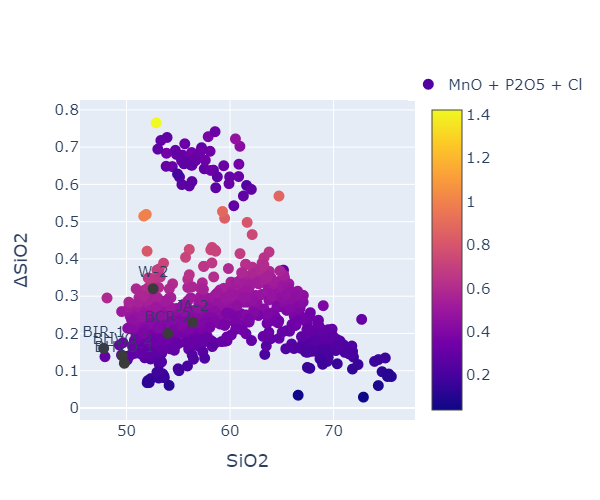

In [11]:
elementos = ['SiO2']# ,'TiO2','Al2O3','FeOT','MgO','CaO','Na2O','K2O']

for elemento in elementos: #['SiO2','Al2O3']:
    plot1 = go.Scatter(x=BOOM_major_renormalized_bulk[elemento+'_normalized'],
               y=BOOM_major_renormalized_bulk['Δ'+elemento],
               mode = 'markers',
               hovertext = 'Sample Observation ID: ' + BOOM_major_renormalized_bulk.SampleObservationID.astype('str') + ' '+ 
                       BOOM_major_renormalized_bulk.Authors.astype('str') + '; LOI:'+ BOOM_major_renormalized_bulk.LOI.astype('str')
                       + '; P2O5:'+ BOOM_major_renormalized_bulk.P2O5.astype('str')
                       + '; MnO:'+ BOOM_major_renormalized_bulk.MnO.astype('str')
                       + '; Cl:'+ BOOM_major_renormalized_bulk.Cl.astype('str')
                       + '; Al2O3:'+ BOOM_major_renormalized_bulk.Al2O3.astype('str')
                       ,
               marker = dict(color=BOOM_major_renormalized_bulk['MnO + P2O5 + Cl'],showscale = True),
               name = "MnO + P2O5 + Cl")

    plot2 = go.Scatter(x = Standards_ref_bulk[elemento],
                  y = Standards_ref_bulk['σ_'+elemento],
                  text = Standards_ref_bulk.StandardID ,
                  hovertext = 'Secondary standard: ' + Standards_ref_bulk.StandardID  , 
                  mode = 'markers+text',
                  textposition = 'top center' ,
                  showlegend = False ,
                  line = {'color': "#3b3b3b"})

    Data = [plot1,plot2]
    layout = go.Layout(xaxis=dict(title=elemento), yaxis=dict(title='Δ'+elemento),
                      legend={'y':1.1, 'x':0.98}, width=600, height=500)# title='Re-normalization variation',
    
    fig = go.Figure(data=Data,layout=layout)
    fig.update_traces(marker = dict(size=11))
    fig.update_layout(font = dict(size=15))
    fig.show('png')